In [2]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Colormap for time
import scienceplots
plt.style.use(['science','nature','no-latex','vibrant'])


from scipy.optimize import curve_fit
from scipy.optimize import minimize


#Import personal functions
import sys
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
import FluidicSetupFunctions
from save_plot_func import save_plot


In [4]:
#Location = r"C:\Users\Olivi\OneDrive - TU Eindhoven\Soft robotic matter\data_analysis"
Location = r"//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Thermal_actuation/Experimental/Fluidic/Actuators"
Foldernames = ["/Data"]

data = FluidicSetupFunctions.LoadData(Foldernames = Foldernames,Location=Location)

print(data[0][-1].head)

#check check


Loading... Folder 1 of 1, Sample 1 of 5
Loading... Folder 1 of 1, Sample 2 of 5
Loading... Folder 1 of 1, Sample 3 of 5
Loading... Folder 1 of 1, Sample 4 of 5
Loading... Folder 1 of 1, Sample 5 of 5
<bound method NDFrame.head of         flowFesto-1  DigOut-1   SSCDP30-9     Time
0          0.000037       0.0   50.559083    0.001
1         -0.000010       0.0   40.280822    0.002
2         -0.000120       0.0   31.262755    0.003
3         -0.000281       0.0   23.466631    0.004
4         -0.000481       0.0   16.854201    0.005
...             ...       ...         ...      ...
211295     0.001067       0.0  230.873302  211.296
211296     0.001259       0.0  234.478685  211.297
211297     0.001422       0.0  237.512370  211.298
211298     0.001553       0.0  239.694656  211.299
211299     0.001645       0.0  240.745842  211.300

[211300 rows x 4 columns]>


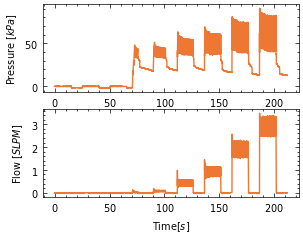

In [22]:
P = data[0][0]['SSCDP30-9']/1000
t = data[0][0]['Time']
Q = data[0][0]['flowFesto-1']


ax1=plt.subplot(211)
plt.plot(t,P)
plt.ylabel('Pressure [$kPa$]')

ax2 = plt.subplot(212,sharex=ax1)
plt.plot(t,Q)
plt.xlabel('Time[$s$]')
plt.ylabel('Flow [$SLPM$]')
plt.show()

Prepare data: slice per run

In [307]:
# Slice data per run 

data_sliced = []
for index,value in enumerate(data[0]):
    runs = [] # new list for all the runs in data[0]
    start = 0
    run_count = 1  # Counter for run numbe
    #flow = data[0][index]['AWM5-5'].values

    # Check which pressure sensor is used 
    df = data[0][index]
    print(index)

    P = data[0][0]['SSCDP30-9']/1000
    t = data[0][0]['Time']
    Q = data[0][0]['flowFesto-1']
   

    while start < len(data[0][index]['DigOut-1']):
        start = np.argmax(data[0][index]['DigOut-1'][start:] == 1) +start  # Correcting index for slicing
        end = np.argmax(data[0][index]['DigOut-1'][start:] == 0)+start   # Correcting index for slicing
        
        if end <= start:  # Break if no more valid segments are found
            break

        # Reschale the flow data to compensate for drifting 
        first_value = Q[start]
        flow_rescaled =Q[start:end] - first_value
      
        # Create a DataFrame for this run
        run_df = pd.DataFrame({
            'Time': np.arange(start, end),  # You can replace this with the actual time data if you have it
            'Rescaled_Flow': flow_rescaled[:end - start],
            'Pressure': P[start:end]/1000   # Assuming P is already an array
        })

        # Append this DataFrame to the list
        runs.append(run_df)   

        start = end + 5  # Move to next segment
        run_count += 1  # Increment run counter
    data_sliced.append(runs)

#Remove wrong measurement
#data_sliced[0].pop(8)   # touched setup with finger and messed up flow measurement


0
1
2
3


In [ ]:
len(data_sliced)

Extract opening and closing pressure

In [308]:

# Function for moving average smoothing
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Plot sliced data and extract opening pressure 
P_open = []
P_close = []

open_threshold = 0.1 # slpm
close_threshold = 0.09 # slpm

# Window size for smoothing
window_size = 100  # You can adjust this value based on your requirements

# Initialize a flag to indicate whether the threshold has been crossed from below
crossed_threshold = False

for sample in data_sliced:   
    # Initialize lists for each sample
    P_open_sample = []
    P_close_sample = []
    
    for run in sample:
        Q_raw = run['Rescaled_Flow']
        P_raw = run['Pressure']
        
        # Apply moving average smoothing
        Q = moving_average(Q_raw, window_size)
        P_sliced = moving_average(P_raw, window_size)
        
        # Extract opening pressure
        opening_index = np.argmax(Q > open_threshold)  # If the flow passes a certain threshold, then we can assume it is open
        P_open_sample.append(P_sliced[opening_index])  # Use previous index to recover the pressure 
        
        # Loop through the data
        for jj in range(1, len(Q)):
            # Check for crossing the threshold from below to above
            if Q[jj] > close_threshold:
                crossed_threshold = True
            
            # Check for crossing the threshold from above to below after it's been crossed from below
            if crossed_threshold and Q[jj] < close_threshold:
                P_close_sample.append(P_sliced[jj])
                
                # Reset the flag if you are only interested in the first such occurrence
                crossed_threshold = False
                break
    
    # Append the lists for each sample to the main lists
    P_open.append(P_open_sample)
    P_close.append(P_close_sample)

Results